In [256]:
import numpy as np
import pandas as pd
import patsy as pt
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')

## 7.8 Lab: Non-Linear Modelling

Load wage dataset

In [284]:
wage_df = pd.read_csv('./data/Wage.csv')
wage_df = wage_df.drop(wage_df.columns[0], axis=1)

wage_df['education'] = wage_df['education'].map({'1. < HS Grad': 1.0, 
                                                 '2. HS Grad': 2.0, 
                                                 '3. Some College': 3.0,
                                                 '4. College Grad': 4.0,
                                                 '5. Advanced Degree': 5.0
                                                })

wage_df.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1.0,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4.0,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3.0,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4.0,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2.0,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


### Polynomial regression

In [285]:
# Derive 4 degree polynomial features of age
degree = 4
f = ' + '.join(['np.power(age, {})'.format(i) for i in np.arange(1, degree+1)])
X = pt.dmatrix(f, wage_df)
y = np.asarray(wage_df['wage'])

In [286]:
# Fit linear model
model = sm.OLS(y, X).fit()
y_hat = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Sun, 14 Oct 2018   Prob (F-statistic):           2.77e-57
Time:                        17:48:26   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -184.1542     60.040     -3.067      0.002    -301.879     -66.430
x1            21.2455      5.887      3.609      0.000       9.703      32.788
x2            -0.5639      0.206     -2.736      0.006      -0.968      -0.160
x3             0.0068      0.003      2.221      0.026       0.001       0.013
x4         -3.204e-05   1.64e-05     -1.952      0.051   -6.42e-05    1.45e-07
==============================================================================
Omnibus:                     1097.594   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4965.521
Skew:                           1.722   Prob(JB):                         0.00
Kurtosis:                       8.279   Cond. No.                     5.67e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.67e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

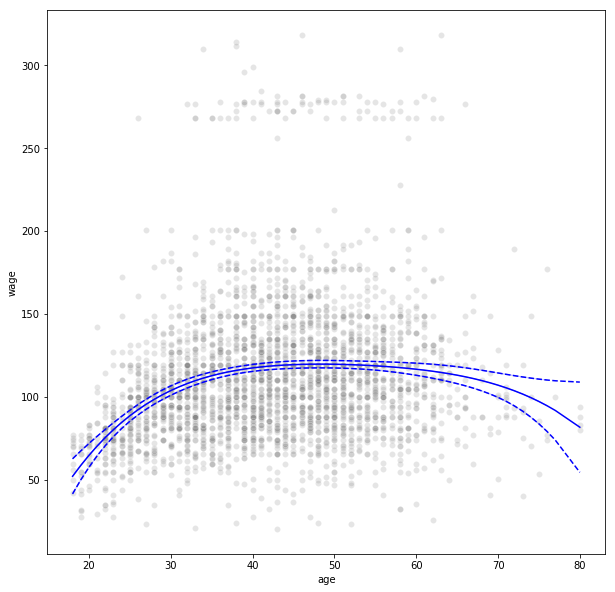

In [287]:
# STATS
# ----------------------------------
# Reference: https://stats.stackexchange.com/questions/44838/how-are-the-standard-errors-of-coefficients-calculated-in-a-regression

# Covariance of coefficient estimates
mse = np.sum(np.square(y_hat - y)) / y.size
cov = mse * np.linalg.inv(X.T @ X)
# ...or alternatively this stat is provided by stats models:
#cov = model.cov_params()

# Calculate variance of f(x)
var_f = np.diagonal((X @ cov) @ X.T)
# Derive standard error of f(x) from variance
se       = np.sqrt(var_f)
conf_int = 2*se

# PLOT
# ----------------------------------
# Setup axes
fig, ax = plt.subplots(figsize=(10,10))

# Plot datapoints
sns.scatterplot(x='age', y='wage',
                color='tab:gray',
                alpha=0.2,
                ax=ax,
                data=pd.concat([wage_df['age'], wage_df['wage']], axis=1));

# Plot estimated f(x)
sns.lineplot(x=X[:, 1], y=y_hat, ax=ax, color='blue');

# Plot confidence intervals
sns.lineplot(x=X[:, 1], y=y_hat+conf_int, color='blue');
sns.lineplot(x=X[:, 1], y=y_hat-conf_int, color='blue');
# dash confidnece int
ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")

### Selecting degrees of freedom for polynomial regression with ANOVA

**ISL Authors:** In performing a polynomial regression we must decide on the degree of the polynomial to use. One way to do this is by using hypothesis tests. We now fit models ranging from linear to a degree-5 polynomial and seek to determine the simplest model which is sufficient to explain the relationship between wage and age.

In [288]:
# Derive 5 degree polynomial features of age
degree = 5
f = ' + '.join(['np.power(age, {})'.format(i) for i in np.arange(1, degree+1)])
X = pt.dmatrix(f, wage_df)
y = np.asarray(wage_df['wage'])

# Get models of increasing degrees
model_1 = sm.OLS(y, X[:, 0:2]).fit()
model_2 = sm.OLS(y, X[:, 0:3]).fit()
model_3 = sm.OLS(y, X[:, 0:4]).fit()
model_4 = sm.OLS(y, X[:, 0:5]).fit()
model_5 = sm.OLS(y, X[:, 0:6]).fit()

# Compare models with ANOVA
display(sm.stats.anova_lm(model_1, model_2, model_3, model_4, model_5))

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


**ISL Authors:** The p-value comparing the linear Model 1 to the quadratic Model 2 is essentially zero (<10−15), indicating that a linear fit is not sufficient. Sim- ilarly the p-value comparing the quadratic Model 2 to the cubic Model 3 is very low (0.0017), so the quadratic fit is also insufficient. The p-value comparing the cubic and degree-4 polynomials, Model 3 and Model 4, is ap- proximately 5 % while the degree-5 polynomial Model 5 seems unnecessary because its p-value is 0.37. Hence, either a cubic or a quartic polynomial appear to provide a reasonable fit to the data, but lower- or higher-order models are not justified.

In [289]:
model_5.pvalues

array([0.75818559, 0.84262114, 0.77341959, 0.56366932, 0.4460959 ,
       0.36968197])

**Revision note:** ISL suggests that the above results should be same as for annova pvalues, but that isn;t observed here us statsmodels. Why?


**ISL Authors:** However, the ANOVA method works whether or not we used orthogonal polynomials; it also works when we have other terms in the model as well. For example, we can use anova() to compare these three models:

In [292]:
# Derive 5 degree polynomial features of age
degree = 3
f = 'education +' + ' + '.join(['np.power(age, {})'.format(i) for i in np.arange(1, degree+1)])
X = pt.dmatrix(f, wage_df)
y = np.asarray(wage_df['wage'])

# Get models of increasing degrees
model_1 = sm.OLS(y, X[:, 0:3]).fit()
model_2 = sm.OLS(y, X[:, 0:4]).fit()
model_3 = sm.OLS(y, X[:, 0:5]).fit()

# Compare models with ANOVA
display(sm.stats.anova_lm(model_1, model_2, model_3))

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2997.0,3.902335e+06,0.0,NaN,NaN,NaN
1,2996.0,3.759472e+06,1.0,142862.701185,113.991883,3.838075e-26
2,2995.0,3.753546e+06,1.0,5926.207070,4.728593,2.974318e-02


### Polynomial logistic regression with bootstrapped confidence intervals

In [442]:
# Create logistic repsonse for wage > 250
wage_df['wage_above_250'] = (wage_df['wage'] > 250).astype(np.float64)
wage_df.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage,wage_above_250
0,2006,18,1. Never Married,1. White,1.0,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154,0.0
1,2004,24,1. Never Married,1. White,4.0,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020,0.0
2,2003,45,2. Married,1. White,3.0,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177,0.0
3,2003,43,2. Married,3. Asian,4.0,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293,0.0
4,2005,50,4. Divorced,1. White,2.0,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154,0.0


In [401]:
def logit_boot(df, idx):
    # Derive 4 degree polynomial features of age
    degree = 4
    f = ' + '.join(['np.power(age, {})'.format(i) for i in np.arange(1, degree+1)])
    X = pt.dmatrix(f, df.loc[idx])
    y = np.asarray(df['wage_above_250'].loc[idx])
    # Some sample for predictions observations 
    x1_test = np.arange(20,81)
    X_test  = np.array([np.ones(len(x1)), x1, np.power(x1, 2), np.power(x1, 3), np.power(x1, 4)]).T
        
    # Fit logistic regression model
    model = sm.Logit(y, X).fit(disp=0)
    y_hat = model.predict(X_test)
    return y_hat

In [422]:
def tenth_percentile(df, idx):
    Z = np.array(df.loc[idx])
    return np.percentile(Z, 10)

def boot_idx(n):
    """Return index for bootstrap sample of size n
    e.g. generate array in range 0 to n, with replacement"""
    return np.random.randint(low=0, high=n, size=n)

def boot(fn, data_df, samples):
    """Perform bootstrap for B number of samples"""
    results = []
    for s in range(samples):
        Z = fn(data_df, boot_idx(data_df.shape[0]))
        results += [Z]
    return np.array(results)

# Get y_hat for B number of bootstrap samples
B = 1000
boot_obs   = boot(logit_boot, wage_df, samples=B)
SE_pred    = np.std(boot_obs, axis=0) 

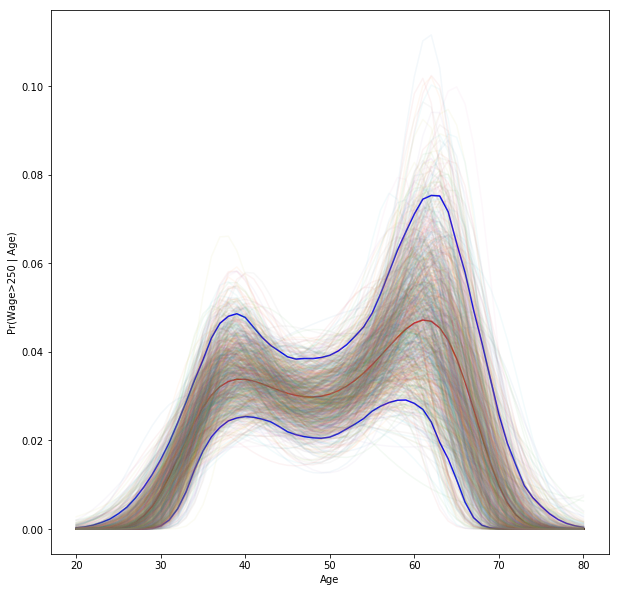

In [441]:
# Calculate 5% and 95% percentiles of y_hat across all bootstrap samples
upper = np.percentile(boot_obs, 95, axis=0)
lower = np.percentile(boot_obs, 5, axis=0)

# Derive 4 degree polynomial features of age
degree = 4
f = ' + '.join(['np.power(age, {})'.format(i) for i in np.arange(1, degree+1)])
X = pt.dmatrix(f, wage_df)
y = np.asarray(wage_df['wage_above_250'])
# Some test observations 
x1_test = np.arange(20,81)
X_test  = np.array([np.ones(len(x1)), x1, np.power(x1, 2), np.power(x1, 3), np.power(x1, 4)]).T

# Fit logistic regression model
model = sm.Logit(y, X).fit(disp=0)
y_hat = model.predict(X_test)


# Setup axes
fig, ax = plt.subplots(figsize=(10,10))
plot_df = pd.DataFrame({'Age': x1_test, 'Pr(Wage>250 | Age)': y_hat})
sns.lineplot(x='Age', y='Pr(Wage>250 | Age)', data=plot_df, color='red')

sns.lineplot(x=x1_test, y=upper, color='blue');
sns.lineplot(x=x1_test, y=lower, color='blue');

# Plot all f(x) estimations
for b in boot_obs:
    #plot_df = pd.DataFrame({'Age': boot_obs[0][:, 0], 'Pr(Wage>250 | Age)': boot_obs[0][:, 1]})
    sns.lineplot(x=x1_test, y=b, alpha=0.05)

Here I've used the bootstrap sampling method to get estimates of f(x) for 1000 samples of the dataset. The 5th and 95th percentile of these estimates are shown in blue. The estimate for f(x) using the full dataset is shown in red. 

**Revision note:** I expected the 5th and 95th percentiles to correspond to the confidence intervals reported by the ISL authors. They are largely similar except for the higher bound for high values of age which tends to zero here but for the ISL authors tends to 1.

### Step function

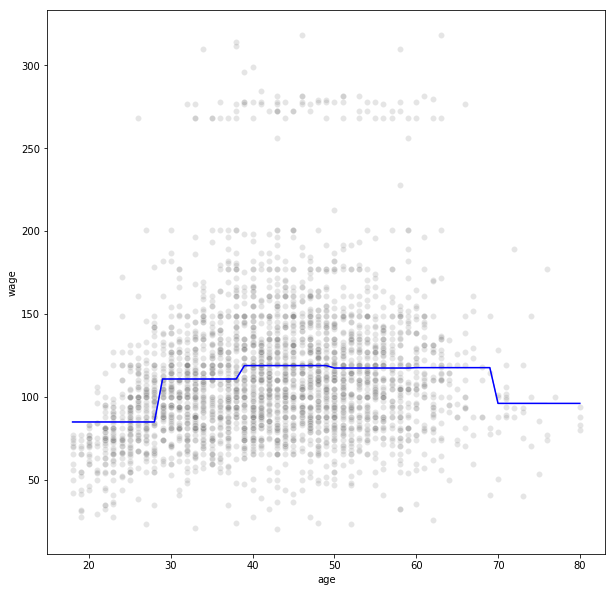

In [472]:
### Step function
steps = 6

# Segment data into 4 segments by age
cuts = pd.cut(wage_df['age'], steps)
X = np.asarray(pd.get_dummies(cuts))
y = np.asarray(wage_df['wage'])

# Fit logistic regression model
model = sm.OLS(y, X).fit(disp=0)
y_hat = model.predict(X)


# PLOT
# ----------------------------------
# Setup axes
fig, ax = plt.subplots(figsize=(10,10))

# Plot datapoints
sns.scatterplot(x='age', y='wage',
                color='tab:gray',
                alpha=0.2,
                ax=ax,
                data=pd.concat([wage_df['age'], wage_df['wage']], axis=1));

# Plot estimated f(x)
sns.lineplot(x=wage_df['age'], y=y_hat, ax=ax, color='blue');

## 7.8.2 Splines


In [498]:
# Putting confidence interval calcs into function for convenience.

def confidence_interval(X, y, y_hat):
    """Compute 5% confidence interval for linear regression"""
    # STATS
    # ----------------------------------
    # Reference: https://stats.stackexchange.com/questions/44838/how-are-the-standard-errors-of-coefficients-calculated-in-a-regression
    
    # Covariance of coefficient estimates
    mse = np.sum(np.square(y_hat - y)) / y.size
    cov = mse * np.linalg.inv(X.T @ X)
    # ...or alternatively this stat is provided by stats models:
    #cov = model.cov_params()
    
    # Calculate variance of f(x)
    var_f = np.diagonal((X @ cov) @ X.T)
    # Derive standard error of f(x) from variance
    se       = np.sqrt(var_f)
    conf_int = 2*se
    return conf_int

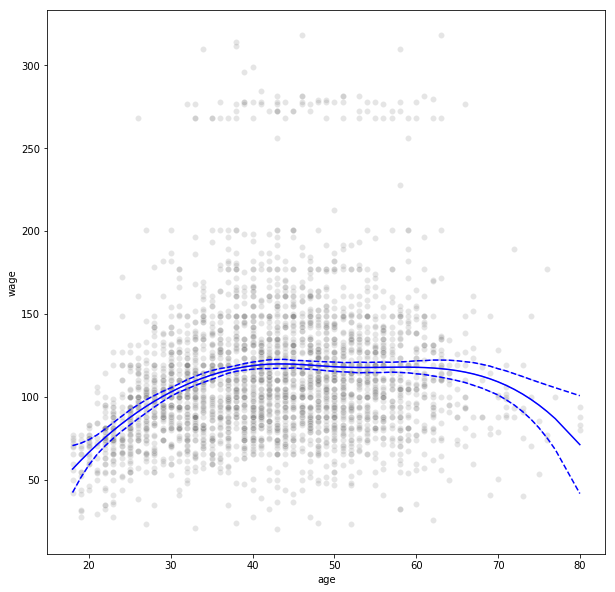

In [505]:
# Fit spline with 6 degrees of freedom

# Use patsy to generate entire matrix of basis functions
X = pt.dmatrix('bs(age, df=7, degree=3, include_intercept=True)', wage_df)
y = np.asarray(wage_df['wage'])

# Fit logistic regression model
model = sm.OLS(y, X).fit(disp=0)
y_hat = model.predict(X)
conf_int = confidence_interval(X, y, y_hat)

# PLOT
# ----------------------------------
# Setup axes
fig, ax = plt.subplots(figsize=(10,10))

# Plot datapoints
sns.scatterplot(x='age', y='wage',
                color='tab:gray',
                alpha=0.2,
                ax=ax,
                data=pd.concat([wage_df['age'], wage_df['wage']], axis=1));

# Plot estimated f(x)
sns.lineplot(x=wage_df['age'], y=y_hat, ax=ax, color='blue');

# Plot confidence intervals
sns.lineplot(x=wage_df['age'], y=y_hat+conf_int, color='blue');
sns.lineplot(x=wage_df['age'], y=y_hat-conf_int, color='blue');
# dash confidnece int
ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")

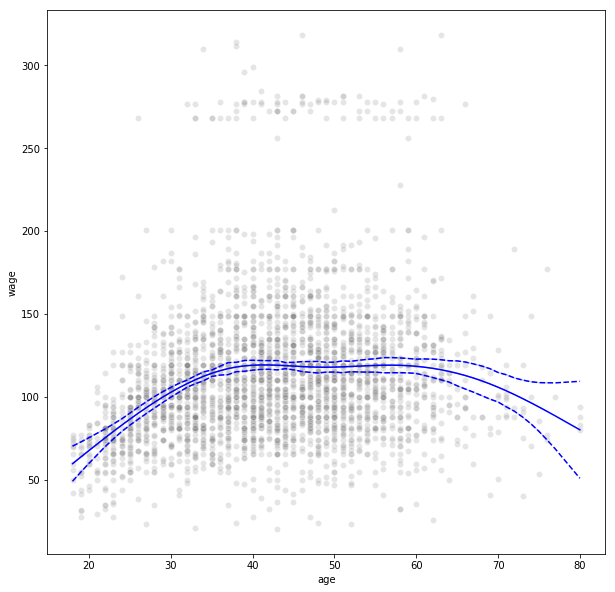

In [507]:
# Fit a natural spline with seven degrees of freedom

# Use patsy to generate entire matrix of basis functions
X = pt.dmatrix('cr(age, df=7)', wage_df)     # REVISION NOTE: Something funky happens when df=6
y = np.asarray(wage_df['wage'])

# Fit logistic regression model
model = sm.OLS(y, X).fit(disp=0)
y_hat = model.predict(X)
conf_int = confidence_interval(X, y, y_hat)

# PLOT
# ----------------------------------
# Setup axes
fig, ax = plt.subplots(figsize=(10,10))

# Plot datapoints
sns.scatterplot(x='age', y='wage',
                color='tab:gray',
                alpha=0.2,
                ax=ax,
                data=pd.concat([wage_df['age'], wage_df['wage']], axis=1));

# Plot estimated f(x)
sns.lineplot(x=wage_df['age'], y=y_hat, ax=ax, color='blue');

# Plot confidence intervals
sns.lineplot(x=wage_df['age'], y=y_hat+conf_int, color='blue');
sns.lineplot(x=wage_df['age'], y=y_hat-conf_int, color='blue');
# dash confidnece int
ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")

Comparing the above two plots we can see the increased linearity of the natural spline at the boundaries of age. This seems to yield a slight increase in confidence at the extremes of age.

The ISLR authors cover smoothing splines in addition to the above. Smoothing splines seem to be poorly supported in python, I could only find `scipy.interpolate.UnivariateSpline`.



### 7.8.3 GAMs

**ISL Authors:** We now fit a GAM to predict wage using natural spline functions of year and age, treating education as a qualitative predictor, as in (7.16). Since this is just a big linear regression model using an appropriate choice of basis functions, we can simply do this using the lm() function.

In [517]:
# Use patsy to generate entire matrix of basis functions
X = pt.dmatrix('cr(year, df=4)+cr(age, df=5) + education', wage_df)
y = np.asarray(wage_df['wage'])

# Fit logistic regression model
model = sm.OLS(y, X).fit(disp=0)
y_hat = model.predict(X)
conf_int = confidence_interval(X, y, y_hat)

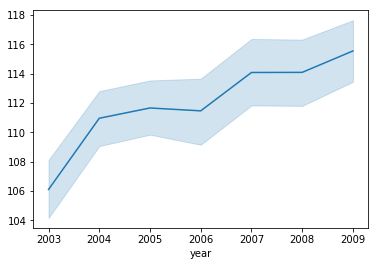

In [530]:
# Plot estimated f(year)
sns.lineplot(x=wage_df['year'], y=y_hat);

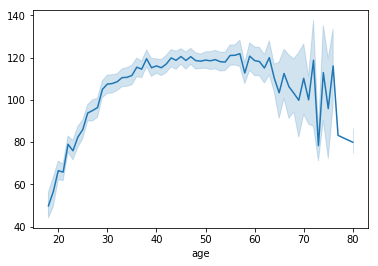

In [529]:
# Plot estimated f(age)
sns.lineplot(x=wage_df['age'], y=y_hat);

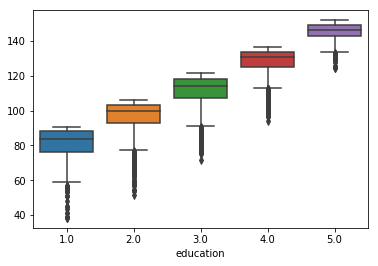

In [528]:
# Plot estimated f(education)
sns.boxplot(x=wage_df['education'], y=y_hat);

Not quite the same as plots achived by ISL authors using R, but gives similar insight.


### Comparing GAM configurations with ANOVA

In [538]:
# Model 1
X = pt.dmatrix('cr(age, df=5) + education', wage_df)
y = np.asarray(wage_df['wage'])
model1 = sm.OLS(y, X).fit(disp=0)
# Model 2
X = pt.dmatrix('year+cr(age, df=5) + education', wage_df)
y = np.asarray(wage_df['wage'])
model2 = sm.OLS(y, X).fit(disp=0)
# Model 3
X = pt.dmatrix('cr(year, df=4)+cr(age, df=5) + education', wage_df)
y = np.asarray(wage_df['wage'])
model3 = sm.OLS(y, X).fit(disp=0)

# Compare models with ANOVA
display(sm.stats.anova_lm(model1, model2, model3))

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2994.0,3.750437e+06,0.0,NaN,NaN,NaN
1,2993.0,3.732809e+06,1.0,17627.473318,14.129318,0.000174
2,2991.0,3.731516e+06,2.0,1293.696286,0.518482,0.595477


The `Pr(>F)` of 0.000174 for `Model 2` suggests that it is significantly better than model 1 whereas with a pvalue > 0.05 model 3 does not seem to be significantly better than model 2.  

We condlude that inclusion of a linear year feature improves the model, but there is no evidence that a non-linear function of year improves the model.

In [543]:
display(model3.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     149.3
Date:                Mon, 15 Oct 2018   Prob (F-statistic):          6.85e-212
Time:                        18:06:12   Log-Likelihood:                -14946.
No. Observations:                3000   AIC:                         2.991e+04
Df Residuals:                    2991   BIC:                         2.996e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.3493      1.799     21.317      0.000      34.822      41.877
x1             5.1741      1.366      3.788      0.000       2.496       7.853
x2             9.3791      1.242      7.550      0.000       6.943      11.815
x3            11.1966      1.294      8.654      0.000       8.660      13.733
x4            12.5995      1.519      8.292      0.000       9.620      15.579
x5           -22.7665      3.283     -6.935      0.000     -29.203     -16.330
x6            15.6588      2.343      6.684      0.000      11.066      20.252
x7            24.5870      1.987     12.372      0.000      20.690      28.484
x8            19.8888      2.546      7.810      0.000      14.896      24.882
x9             0.9812      7.953      0.123      0.902     -14.613      16.576
x10           15.2726      0.536     28.479      0.000      14.221      16.324
==============================================================================
Omnibus:                     1061.067   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5669.217
Skew:                           1.594   Prob(JB):                         0.00
Kurtosis:                       8.933   Cond. No.                     2.69e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.96e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Inspecting the pvalues for model 3 features we note a pvalue >0.05 for x9 which correspondes to the 5th degree of freedom for age. 

**Revision note:** The ISL authors report high pvalues for year features, which would reinforce the above ANOVA result, but we can't see that here. Perhaps the OLS `.summary()` is not equivalent to R's `summary(gam)`

### Local Regression GAM

In [573]:
x = np.asarray(wage_df['age'])
y = np.asarray(wage_df['wage'])
# Create lowess feature for age
wage_df['age_lowess'] = sm.nonparametric.lowess(y, x, frac=.7, return_sorted=False)

# Fit logistic regression model
X = pt.dmatrix('cr(year, df=4)+ age_lowess + education', wage_df)
y = np.asarray(wage_df['wage'])
model = sm.OLS(y, X).fit(disp=0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     239.0
Date:                Mon, 15 Oct 2018   Prob (F-statistic):          2.74e-215
Time:                        18:39:17   Log-Likelihood:                -14946.
No. Observations:                3000   AIC:                         2.990e+04
Df Residuals:                    2994   BIC:                         2.994e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -38.2295      5.977     -6.396      0.000     -49.949     -26.510
x1           -14.0090      1.973     -7.102      0.000     -17.877     -10.141
x2            -9.7151      1.886     -5.151      0.000     -13.413      -6.017
x3            -7.9607      1.917     -4.153      0.000     -11.719      -4.202
x4            -6.5447      2.091     -3.129      0.002     -10.645      -2.444
x5             1.0823      0.071     15.208      0.000       0.943       1.222
x6            15.3535      0.534     28.746      0.000      14.306      16.401
==============================================================================
Omnibus:                     1056.253   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5640.862
Skew:                           1.585   Prob(JB):                         0.00
Kurtosis:                       8.922   Cond. No.                     2.70e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.57e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""